<a href="https://colab.research.google.com/github/ManelSoengas/DL_Task2/blob/main/DL_task2_Roberta_15_8_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizamos/no utilizamos los datos aumentados mediante la técnica de swapping. No utilizamos preprocesamiento de los tweets.Además la arquitectura contempla:


1.   Dropout y early_stopping
2.   Asignación de pesos en función del peso de la clase.
3.   La configuración y arquitectura se mantienen.
4.   Se utiliza RoBERTa para el idioma inglés.




# **Cargar los recursos necesarios.**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00


#**Cargar los datos de entrada**

In [2]:
from sklearn.utils import shuffle
# Cargar datos preprocesados
#train_data = pd.read_csv('/content/EXIST2021_training.tsv', delimiter=',', encoding='latin1')
#test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', delimiter=',', encoding='latin1')

import pandas as pd

# Leer los archivos TSV y seleccionar las columnas deseadas y filtrar por idioma 'es'
test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', sep='\t', usecols=['text', 'language', 'task2']).loc[lambda df: df['language'] == 'en']
train_data = pd.read_csv('/content/swapp_EXIST2021_training.tsv', sep='\t', usecols=['text', 'language', 'task2']).loc[lambda df: df['language'] == 'en']
#swapping data_set training
# Mezclar los datos de entrenamiento
shuffled_train_data = shuffle(train_data, random_state=42)

# Mezclar los datos de prueba
shuffled_test_data = shuffle(test_data, random_state=42)


# **Visualizar estructura de los datos**

In [3]:
shuffled_train_data.head(10)

,language,text,task2
1713,en,You look like a prostitute whore Nancy.,objectification
1637,en,https://t.co/GCFMRVxyfO #Athleisure #Entrepren...,non-sexist
929,en,Nice tits X https://t.co/nmoaFbpJ4D,objectification
2967,en,"O.C. After much consideration, Ellen Page is ...",non-sexist
203,en,"the only problem with that is, you have to go ...",non-sexist
1494,en,@365Spanking Wish I can find some one in my ho...,sexual-violence
2380,en,"Our military commits war crimes, our cops comm...",non-sexist
1465,en,353.// A beautiful king !! So proud of you @l...,non-sexist
557,en,"nsfw, violence//--ALSO is makima from chainsaw...",objectification
567,en,Happy summer day (very hot) in a very short sk...,non-sexist


# **Distribución de la clase objetivo**

In [3]:

columna_clase_objetivo = "task2"

df = shuffled_train_data

# Contar la cantidad de categorías únicas en la columna de la clase objetivo
cantidad_categorias = df[columna_clase_objetivo].nunique()

# Contar la cantidad de muestras para cada categoría de la clase objetivo
muestras_por_categoria = df[columna_clase_objetivo].value_counts()

# Imprimir los resultados
print("Cantidad de categorías:", cantidad_categorias)
print("Muestras por categoría:")
print(muestras_por_categoria)
df.shape[0]

Cantidad de categorías: 6
Muestras por categoría:
non-sexist                      3104
ideological-inequality           672
stereotyping-dominance           626
sexual-violence                  590
misogyny-non-sexual-violence     494
objectification                  450
Name: task2, dtype: int64


5936

# **Carga de los recursos RoBERTa**

In [5]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            truncation_strategy='longest_first',
            return_attention_mask=True

        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [6]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")


# **Configuración**

In [4]:
MAX_LEN=255


In [7]:
X = shuffled_train_data['text'].values
y = shuffled_train_data['task2'].values
Z = shuffled_test_data['text'].values
z = shuffled_test_data['task2'].values

In [8]:
# Dividir los datos en entrenamiento y prueba
train_text, val_text, train_task2, val_task2 = train_test_split(X, y, test_size=0.2, random_state=42)

# **Codificación**

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Crear un objeto LabelEncoder para convertir las etiquetas de clase en valores numéricos
label_encoder = LabelEncoder()

# Ajustar el encoder con los datos de train_task2
label_encoder.fit(train_task2)

# Aplicar la transformación a los conjuntos de datos
train_task2_encoded = label_encoder.transform(train_task2)
val_task2_encoded = label_encoder.transform(val_task2)
z_encoded = label_encoder.transform(z)

# Ahora puedes usar train_task2_encoded, val_task2_encoded y z_encoded en tu modelo de clasificación

# Si deseas codificar las etiquetas de clase como one-hot encoded, utiliza OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Ajustar el encoder one-hot con las etiquetas codificadas numéricamente
onehot_encoder.fit(train_task2_encoded.reshape(-1, 1))

# Aplicar la transformación one-hot a los conjuntos de datos
train_task2_onehot = onehot_encoder.transform(train_task2_encoded.reshape(-1, 1))
val_task2_onehot = onehot_encoder.transform(val_task2_encoded.reshape(-1, 1))
z_onehot = onehot_encoder.transform(z_encoded.reshape(-1, 1))

# Ahora train_task2_onehot, val_task2_onehot y z_onehot contienen las etiquetas de clase codificadas como one-hot

Estoy utilizando **LabelBinarizer** de Scikit-Learn para convertir las etiquetas de clase en codificación one-hot. La principal diferencia aquí es que uso fit una vez para ajustar el codificador con las etiquetas de clase, y luego uso transform para convertir las etiquetas de cada conjunto de datos (entrenamiento, validación, prueba) en codificación one-hot. Esto asegura que las mismas transformaciones se apliquen a todas las etiquetas, lo que es importante para mantener la consistencia.



In [9]:
from sklearn.preprocessing import LabelBinarizer

etiquetas_clase = ["non-sexist", "ideological-inequality", "stereotyping-dominance", "misogyny-non-sexual-violence", "sexual-violence", "objectification"]

# Crear un objeto LabelBinarizer para convertir las etiquetas de clase en one-hot encoding
label_binarizer = LabelBinarizer()

# Ajustar el LabelBinarizer con las etiquetas de clase
label_binarizer.fit(etiquetas_clase)

# Transformar las etiquetas de clase en one-hot encoding
train_task2_onehot = label_binarizer.transform(train_task2)
val_task2_onehot = label_binarizer.transform(val_task2)
z_onehot = label_binarizer.transform(z)

In [10]:
import numpy as np
train_input_ids, train_attention_masks = tokenize_roberta(train_text, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(val_text, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(Z, MAX_LEN)

In [11]:
print(train_input_ids.shape)
print(val_input_ids.shape)
print(test_input_ids.shape)

(4748, 255)
(1188, 255)
(2208, 255)


# **Cáculo y asignación de los pesos**

In [12]:
import numpy as np

# Frecuencias de las categorías
muestras_por_categoria = {
    "non-sexist": 3104,
    "ideological-inequality": 672,
    "stereotyping-dominance": 626,
    "misogyny-non-sexual-violence": 494,
    "sexual-violence": 590,
    "objectification": 450
}

total_muestras = sum(muestras_por_categoria.values())

# Calcular las frecuencias relativas
frecuencias_relativas = {cat: count / total_muestras for cat, count in muestras_por_categoria.items()}

# Calcular los pesos inversamente proporcionales a las frecuencias
pesos = {cat: 1 / freq for cat, freq in frecuencias_relativas.items()}

# Normalizar los pesos
suma_pesos = sum(pesos.values())
pesos_normalizados = {cat: weight / suma_pesos for cat, weight in pesos.items()}

print(pesos_normalizados)


{'non-sexist': 0.034459338617129444, 'ideological-inequality': 0.15916932599340744, 'stereotyping-dominance': 0.17086547454883352, 'misogyny-non-sexual-violence': 0.21652183616916965, 'sexual-violence': 0.18129116452130473, 'objectification': 0.2376928601501551}


In [13]:
import tensorflow as tf

# Crear el tensor de pesos para la función de pérdida
pesos_array = np.array(list(pesos_normalizados.values()))
pesos_tensor = tf.constant(pesos_array, dtype=tf.float32)

In [14]:
import tensorflow as tf

def create_multiclass_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #loss = tf.keras.losses.SparseCategoricalCrossentropy()
    #accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    #loss = tf.keras.losses.CategoricalCrossentropy()
    loss = weighted_categorical_crossentropy  # Utilizamos la función con pesos

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    output = bert_model([input_ids, attention_masks])
    output = output[1]

    # Agregar Dropout
    output = tf.keras.layers.Dropout(0.5)(output)

    # Cambiar la salida para clasificación multiclase (6 clases)
    output = tf.keras.layers.Dense(6, activation='softmax')(output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compilar el modelo
    # Cambiar la métrica de BinaryAccuracy a CategoricalAccuracy
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Compilar el modelo
    model.compile(opt, loss=loss, metrics=[accuracy])

    # Agregar Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')

    return model, early_stopping

    # Función de pérdida ponderada
#def weighted_categorical_crossentropy(y_true, y_pred):
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    #weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    #unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    #weighted_loss = unweighted_loss * weights
    #return tf.reduce_mean(weighted_loss)

    # Función de pérdida ponderada
def weighted_categorical_crossentropy(y_true, y_pred):
    # Convertir y_true a float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)



In [15]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [16]:
#model = create_model(roberta_model, MAX_LEN)
model, early_stopping = create_multiclass_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 255,                                           

In [17]:
#history_2 = model.fit([train_input_ids,train_attention_masks], train_task2_onehot, validation_data=([val_input_ids,val_attention_masks], val_task2_onehot), epochs=8, batch_size=16)
history_2 = model.fit(
    [train_input_ids, train_attention_masks], train_task2_onehot,
    validation_data=([val_input_ids, val_attention_masks], val_task2_onehot),
    epochs=8,
    batch_size=32,
    callbacks=[early_stopping]  # Aquí se añade la devolución anticipada como callback
)

Epoch 1/8
149/149 [==============================] - 344s 2s/step - loss: 0.2192 - categorical_accuracy: 0.5084 - val_loss: 0.1507 - val_categorical_accuracy: 0.6069
Epoch 2/8
149/149 [==============================] - 286s 2s/step - loss: 0.1455 - categorical_accuracy: 0.6316 - val_loss: 0.1247 - val_categorical_accuracy: 0.6919
Epoch 3/8
149/149 [==============================] - 285s 2s/step - loss: 0.1067 - categorical_accuracy: 0.7102 - val_loss: 0.0965 - val_categorical_accuracy: 0.7399
Epoch 4/8
149/149 [==============================] - 265s 2s/step - loss: 0.0752 - categorical_accuracy: 0.7917 - val_loss: 0.0890 - val_categorical_accuracy: 0.7803
Epoch 5/8
149/149 [==============================] - 285s 2s/step - loss: 0.0515 - categorical_accuracy: 0.8454 - val_loss: 0.0828 - val_categorical_accuracy: 0.7997
Epoch 6/8
149/149 [==============================] - 285s 2s/step - loss: 0.0372 - categorical_accuracy: 0.8823 - val_loss: 0.0771 - val_categorical_accuracy: 0.8274
Epoc

In [18]:
result_roberta = model.predict([test_input_ids,test_attention_masks])


69/69 [==============================] - 40s 558ms/step


In [19]:
# Evaluar el modelo
evaluation = model.evaluate([test_input_ids, test_attention_masks], z_onehot)

# Imprimir los resultados de la evaluación
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

69/69 [==============================] - 39s 561ms/step - loss: 0.2866 - categorical_accuracy: 0.5874
Loss: 0.2865637242794037
Accuracy: 0.5874094367027283


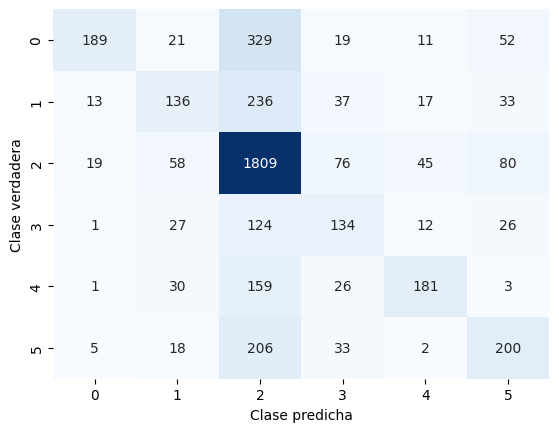

In [ ]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que z_test.argmax(1) son las etiquetas reales y y_pred_roberta.argmax(1) son las etiquetas predichas
cm = confusion_matrix(z_onehot.argmax(1), y_pred_roberta.argmax(1))

# Crear un heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Añadir etiquetas a los ejes
plt.xlabel("Clase predicha")
plt.ylabel("Clase verdadera")

# Mostrar el gráfico
plt.show()

# **Resultados**


---

Para 8 epochs, lr = 0.00001, batch_size = 32, datos no preprocesados, sin datos  ampliados mediante técnica swapping y aplicación de pesos para compensar las clases minoritárias se obtiene:

##Training

```
Epoch 1/8
86/86 [==============================] - 246s 2s/step - loss: 0.2482 - categorical_accuracy: 0.4585 - val_loss: 0.2038 - val_categorical_accuracy: 0.5247
Epoch 2/8
86/86 [==============================] - 159s 2s/step - loss: 0.1905 - categorical_accuracy: 0.5473 - val_loss: 0.1569 - val_categorical_accuracy: 0.6017
Epoch 3/8
86/86 [==============================] - 160s 2s/step - loss: 0.1516 - categorical_accuracy: 0.6223 - val_loss: 0.1419 - val_categorical_accuracy: 0.6119
Epoch 4/8
86/86 [==============================] - 151s 2s/step - loss: 0.1228 - categorical_accuracy: 0.6758 - val_loss: 0.1497 - val_categorical_accuracy: 0.6206
Epoch 5/8
86/86 [==============================] - 160s 2s/step - loss: 0.0970 - categorical_accuracy: 0.7351 - val_loss: 0.1476 - val_categorical_accuracy: 0.6555
```
##Evaluación:


```
69/69 [==============================] - 37s 538ms/step - loss: 0.1719 - categorical_accuracy: 0.5779
Loss: 0.17185792326927185
Accuracy: 0.5778985619544983
```




Para 8 epochs, lr = 0.00001, batch_size = 16, datos no preprocesados, sin datos ampliados mediante técnica swapping y aplicación de pesos para compensar las clases minoritárias se obtiene:

#Training:


```
Epoch 1/8
172/172 [==============================] - 223s 991ms/step - loss: 0.2310 - categorical_accuracy: 0.5156 - val_loss: 0.1973 - val_categorical_accuracy: 0.5422
Epoch 2/8
172/172 [==============================] - 161s 939ms/step - loss: 0.1728 - categorical_accuracy: 0.5786 - val_loss: 0.1472 - val_categorical_accuracy: 0.6250
Epoch 3/8
172/172 [==============================] - 152s 882ms/step - loss: 0.1297 - categorical_accuracy: 0.6612 - val_loss: 0.1393 - val_categorical_accuracy: 0.6468
Epoch 4/8
172/172 [==============================] - 160s 932ms/step - loss: 0.1023 - categorical_accuracy: 0.7216 - val_loss: 0.1414 - val_categorical_accuracy: 0.6686
Epoch 5/8
172/172 [==============================] - 151s 881ms/step - loss: 0.0780 - categorical_accuracy: 0.7835 - val_loss: 0.1586 - val_categorical_accuracy: 0.6584
```
#Evaluación:


```
69/69 [==============================] - 46s 548ms/step - loss: 0.1856 - categorical_accuracy: 0.5729
Loss: 0.185576930642128
Accuracy: 0.5729166865348816
```




Para 8 epochs, lr = 0.00001, batch_size = 16, datos no preprocesados, con datos ampliados mediante técnica swapping y aplicación de pesos para compensar las clases minoritárias se obtiene:

#Training:


```
Epoch 1/8
297/297 [==============================] - 346s 972ms/step - loss: 0.2027 - categorical_accuracy: 0.5493 - val_loss: 0.1462 - val_categorical_accuracy: 0.6128
Epoch 2/8
297/297 [==============================] - 279s 941ms/step - loss: 0.1281 - categorical_accuracy: 0.6683 - val_loss: 0.1072 - val_categorical_accuracy: 0.7374
Epoch 3/8
297/297 [==============================] - 258s 868ms/step - loss: 0.0890 - categorical_accuracy: 0.7614 - val_loss: 0.1081 - val_categorical_accuracy: 0.7382
Epoch 4/8
297/297 [==============================] - 278s 937ms/step - loss: 0.0575 - categorical_accuracy: 0.8294 - val_loss: 0.0855 - val_categorical_accuracy: 0.8005
Epoch 5/8
297/297 [==============================] - 258s 869ms/step - loss: 0.0406 - categorical_accuracy: 0.8726 - val_loss: 0.0742 - val_categorical_accuracy: 0.8401
Epoch 6/8
297/297 [==============================] - 258s 867ms/step - loss: 0.0266 - categorical_accuracy: 0.9158 - val_loss: 0.0749 - val_categorical_accuracy: 0.8418
Epoch 7/8
297/297 [==============================] - 258s 868ms/step - loss: 0.0175 - categorical_accuracy: 0.9360 - val_loss: 0.0847 - val_categorical_accuracy: 0.8443
```

#Evaluación:


```
69/69 [==============================] - 37s 529ms/step - loss: 0.3139 - categorical_accuracy: 0.5892
Loss: 0.31388023495674133
Accuracy: 0.5892210006713867
```




Para 8 epochs, lr = 0.00001, batch_size = 32, datos no preprocesados, con datos ampliados mediante técnica swapping y aplicación de pesos para compensar las clases minoritárias se obtiene:

#Training:


```
Epoch 1/8
149/149 [==============================] - 344s 2s/step - loss: 0.2192 - categorical_accuracy: 0.5084 - val_loss: 0.1507 - val_categorical_accuracy: 0.6069
Epoch 2/8
149/149 [==============================] - 286s 2s/step - loss: 0.1455 - categorical_accuracy: 0.6316 - val_loss: 0.1247 - val_categorical_accuracy: 0.6919
Epoch 3/8
149/149 [==============================] - 285s 2s/step - loss: 0.1067 - categorical_accuracy: 0.7102 - val_loss: 0.0965 - val_categorical_accuracy: 0.7399
Epoch 4/8
149/149 [==============================] - 265s 2s/step - loss: 0.0752 - categorical_accuracy: 0.7917 - val_loss: 0.0890 - val_categorical_accuracy: 0.7803
Epoch 5/8
149/149 [==============================] - 285s 2s/step - loss: 0.0515 - categorical_accuracy: 0.8454 - val_loss: 0.0828 - val_categorical_accuracy: 0.7997
Epoch 6/8
149/149 [==============================] - 285s 2s/step - loss: 0.0372 - categorical_accuracy: 0.8823 - val_loss: 0.0771 - val_categorical_accuracy: 0.8274
Epoch 7/8
149/149 [==============================] - 285s 2s/step - loss: 0.0275 - categorical_accuracy: 0.9061 - val_loss: 0.0799 - val_categorical_accuracy: 0.8283
Epoch 8/8
149/149 [==============================] - 285s 2s/step - loss: 0.0223 - categorical_accuracy: 0.9179 - val_loss: 0.0875 - val_categorical_accuracy: 0.8401
```
#Evaluación:


```
69/69 [==============================] - 39s 561ms/step - loss: 0.2866 - categorical_accuracy: 0.5874
Loss: 0.2865637242794037
Accuracy: 0.5874094367027283
```


